In [ ]:
# install all the modules and libraries 

!sudo apt install python3-rtree
!pip install geopandas

import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# mount google drive to import files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---





---


In [ ]:
# import the trails shapefile 

trails_points = gpd.read_file('/content/drive/MyDrive/colorado_trails/colorado_trails.shp')

In [ ]:
# select only the relevant columns

trails_points = trails_points[['name','lengthmile','x','y','geometry']]

In [ ]:
# calculate the centroid of each trail segment

trails_points['geometry'] = trails_points.centroid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
trails_points

,name,lengthmile,x,y,geometry
0,Sand Creek Trail,0.013456,-104.781471,38.790366,POINT (-104.78147 38.79037)
1,None,0.051872,-104.875426,38.825175,POINT (-104.87541 38.82519)
2,None,0.064545,-104.856094,38.823030,POINT (-104.85615 38.82301)
3,None,0.230304,-104.853631,38.822230,POINT (-104.85367 38.82203)
4,None,0.150331,-104.854122,38.818070,POINT (-104.85412 38.81795)
...,...,...,...,...,...
46324,Blue Heron Trail,0.131538,-105.062622,38.395578,POINT (-105.06262 38.39556)
46325,Blue Heron Trail,0.006216,-105.063796,38.395438,POINT (-105.06380 38.39544)
46326,Blue Heron Trail,0.641689,-105.065377,38.390570,POINT (-105.06488 38.39178)
46327,Continental Divide National Scenic Trail,3.600309,-107.533961,37.796236,POINT (-107.53500 37.79588)


In [ ]:
# import zip codes shapefile

zip = gpd.read_file('/content/drive/MyDrive/colorado_zip_codes/colorado_zip_codes1.shp')

In [ ]:
# select on the relvant columns

zip = zip[['zip_code','geometry']]
zip

,zip_code,geometry
0,80476,"POLYGON ((-105.92508 39.67942, -105.92498 39.6..."
1,80477,"POLYGON ((-106.82822 40.48720, -106.82825 40.4..."
2,80478,"POLYGON ((-105.91747 40.00541, -105.91761 40.0..."
3,80479,"POLYGON ((-106.87023 40.09421, -106.86958 40.0..."
4,80480,"POLYGON ((-106.68032 40.64799, -106.68014 40.6..."
...,...,...
521,80827,"MULTIPOLYGON (((-105.30946 38.98927, -105.3098..."
522,80836,"POLYGON ((-102.67045 39.30115, -102.67963 39.3..."
523,80840,"POLYGON ((-104.90550 39.00634, -104.90513 39.0..."
524,80860,"POLYGON ((-105.07573 38.72341, -105.07570 38.7..."


In [ ]:
zip = zip.to_crs(epsg='4269')

---



---



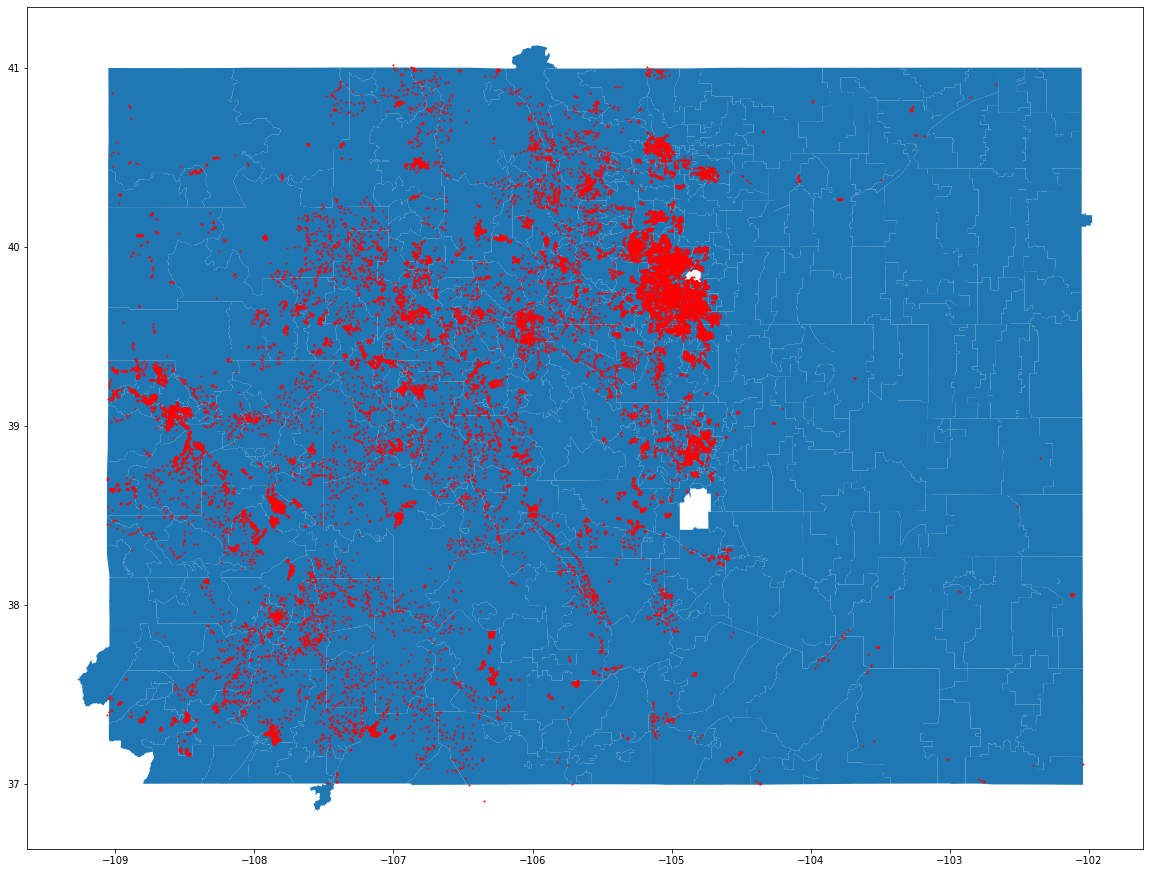

In [ ]:
# check that everything is in place

fig, ax = plt.subplots(1, 1,figsize=(20,20))

zip.plot(ax=ax)
trails_points.plot(ax=ax, color = 'red', markersize = 1)

In [ ]:
# perform a spatial join for the zip codes and trail centroids

trails_in_zip = gpd.sjoin(trails_points, zip, how='right', op='intersects')

In [ ]:
trails_in_zip.head()

,index_left,name,lengthmile,x,y,zip_code,geometry
0,9312.0,Continental Divide National Scenic Trail,0.654411,-105.815997,39.635012,80476,"POLYGON ((-105.92508 39.67942, -105.92498 39.6..."
0,9315.0,Continental Divide National Scenic Trail,3.074662,-105.802530,39.674379,80476,"POLYGON ((-105.92508 39.67942, -105.92498 39.6..."
0,14201.0,Continental Divide National Scenic Trail,2.180240,-105.871479,39.717925,80476,"POLYGON ((-105.92508 39.67942, -105.92498 39.6..."
0,14202.0,Kearney Gulch,1.217341,-105.830609,39.679104,80476,"POLYGON ((-105.92508 39.67942, -105.92498 39.6..."
0,14355.0,Continental Divide National Scenic Trail,0.683225,-105.853309,39.703965,80476,"POLYGON ((-105.92508 39.67942, -105.92498 39.6..."


In [ ]:
# total the length of trails in each zip code and sort

count = (trails_in_zip.groupby(['zip_code']).sum()).sort_values(by=['lengthmile'])

In [ ]:
count.tail()['lengthmile']

zip_code
81611    310.186074
81637    341.282102
81641    410.883440
80480    450.531417
81230    486.431681
Name: lengthmile, dtype: float64

In [ ]:
# the geometry field is lost during the count, so it is put back in using an attribute join

merged = count.merge(trails_in_zip, on = 'zip_code')

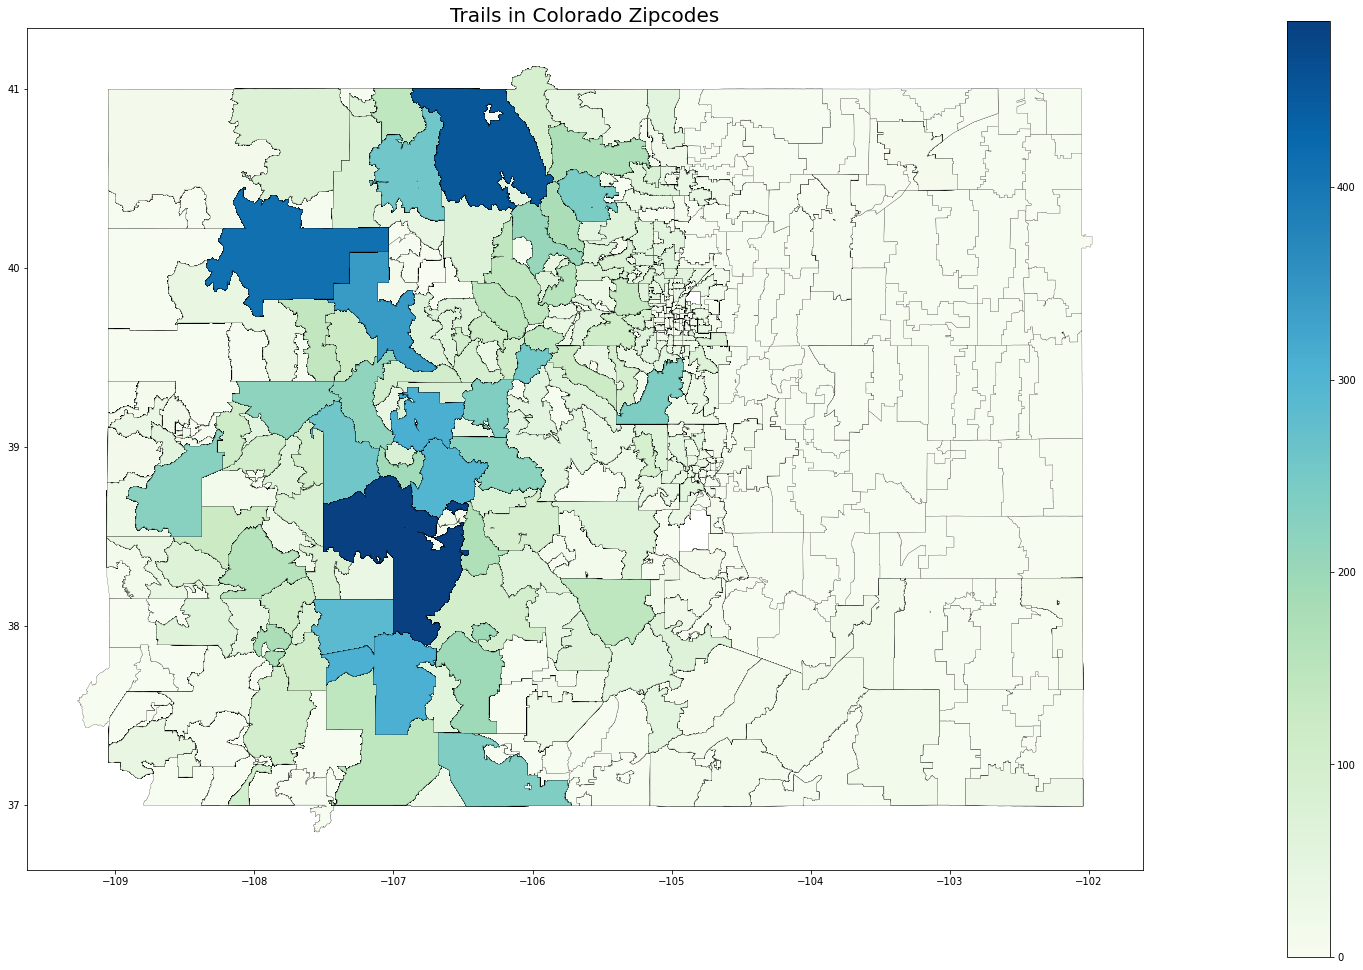

In [ ]:
# plot the results

fig, ax = plt.subplots(1, 1,figsize=(20,20))

merged.plot(column='lengthmile_x', ax=ax, cmap='GnBu',edgecolor='black', linewidth=0.2)

vmin = merged['lengthmile_x'].min()
vmax = merged['lengthmile_x'].max()

plt.title('Trails in Colorado Zipcodes',fontsize=20)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='GnBu')
sm._A = []
cax = fig.add_axes([1, 0.15, 0.03, 0.65])
fig.colorbar(sm, cax=cax)